# Split-apply-combine

**Table of contents**<a id='toc0_'></a>    
- 1. [Groupby](#toc1_)    
- 2. [Split-Apply-Combine](#toc2_)    
    - 2.1.1. [Do the splitting and applying in one fell swoop with `agg()`](#toc2_1_1_)    
    - 2.1.2. [Splitting, applying and combining all together with - `apply()`  and `transform()` directly](#toc2_1_2_)    
- 3. [Optimizing performance](#toc3_)    
    - 3.1.1. [Need more complex group by stuff?](#toc3_1_1_)    
    - 3.1.2. [Additional links](#toc3_1_2_)    
- 4. [Built-in functions to aggregate data in Pandas](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

One of the most useful skills to learn is **the split-apply-combine process**. For example, we may want to compute the average employment rate within a municipality over time and calculate whether the employment rate in each year is above or below the average. We calculate this variable using a split-apply-combine procedure: 

1. **split**: divide the dataset into units (one for each municipality)
2. **apply**: compute the average employment rate for each unit
3. **combine**: merge this new variable back onto the original dataset

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Groupby](#toc0_)

**Example data:**

In [4]:
empl = pd.read_csv('data/RAS200_long.csv')
empl.head()

,municipality,year,empl
0,Copenhagen,2008,72.5
1,Frederiksberg,2008,75.6
2,Dragør,2008,80.5
3,Tårnby,2008,79.0
4,Albertslund,2008,73.1


In [5]:
empl.rename(columns={'empl':'e'}, inplace=True)

In [6]:
# A simple, unconditional transformation of data. Works because of broadcasting. 
empl['empl_demean'] = empl.e - empl.e.mean()
empl.head()

,municipality,year,e,empl_demean
0,Copenhagen,2008,72.5,-1.340249
1,Frederiksberg,2008,75.6,1.759751
2,Dragør,2008,80.5,6.659751
3,Tårnby,2008,79.0,5.159751
4,Albertslund,2008,73.1,-0.740249


In [7]:
empl = empl.sort_values(['municipality','year']) # sort by first municipality then year
empl.head(5)

,municipality,year,e,empl_demean
68,Aabenraa,2008,74.6,0.759751
167,Aabenraa,2009,71.6,-2.240249
266,Aabenraa,2010,70.9,-2.940249
365,Aabenraa,2011,70.2,-3.640249
464,Aabenraa,2012,69.5,-4.340249


Use **groupby** to calculate **within means**:

In [8]:
empl.groupby(['municipality'])['e'].mean().head(5)

municipality
Aabenraa       71.830769
Aalborg        69.846154
Aarhus         69.361538
Albertslund    69.184615
Allerød        81.715385
Name: e, dtype: float64

**Custom functions** the apply part can be specified by using the `lambda` notation. 

**Warning:** `lambda` implementations will often be a pretty slow alternative to *vectorized* operations. More on that later. 

An example with average change:

In [9]:
# Define a lambda function to applied down rows of a column in blocks defined by the groupby. 
avg_first_diff = lambda x: x.diff(1).mean() # A pd.Series has a function diff that does the job.

# Apply the lambda and print head of output
empl.groupby('municipality')['e'].apply(avg_first_diff).head(5)

municipality
Aabenraa      -0.066667
Aalborg       -0.183333
Aarhus        -0.175000
Albertslund   -0.191667
Allerød       -0.100000
Name: e, dtype: float64

Or:

In [10]:
# We can also define our lambda with a numpy implementation. 
avg_first_diff = lambda x: np.mean(x[1:]-x[:-1])

# Need the extra lambda function to retrieve values (aka a numpy array) of e for the avg_first_diff.
empl.groupby('municipality')['e'].apply(lambda x: avg_first_diff(x.values)).head(5) 

municipality
Aabenraa      -0.066667
Aalborg       -0.183333
Aarhus        -0.175000
Albertslund   -0.191667
Allerød       -0.100000
Name: e, dtype: float64

**Plot statistics**: Dispersion in employment rate across Danish municipalities over time.

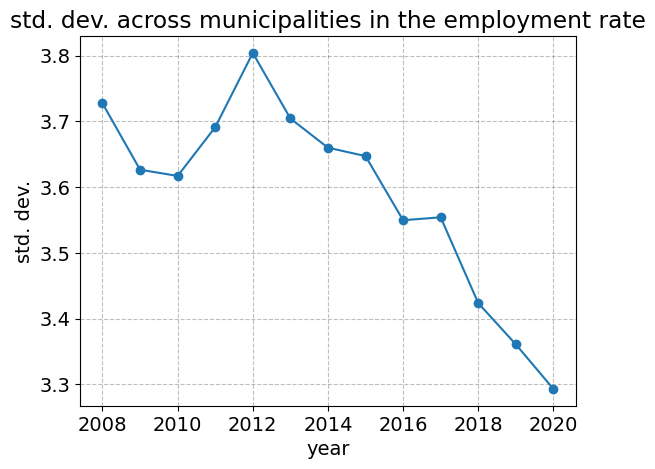

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

empl.groupby('year')['e'].std().plot(ax=ax,style='-o')

ax.set_ylabel('std. dev.')
ax.set_title('std. dev. across municipalities in the employment rate');

## 2. <a id='toc2_'></a>[Split-Apply-Combine](#toc0_)

**Goal:** Calculate within municipality difference to mean employment rate.

**Start** by splitting, applying and combining **manually:**

**1. Split**:

In [12]:
e_grouped = empl.groupby('municipality')['e']

# The e_grouped object is not ready for inspection
print(e_grouped)

**2. Apply:**

In [13]:
e_mean = e_grouped.mean() # mean employment rate
e_mean.head(10)

municipality
Aabenraa       71.830769
Aalborg        69.846154
Aarhus         69.361538
Albertslund    69.184615
Allerød        81.715385
Assens         72.515385
Ballerup       73.330769
Billund        76.769231
Bornholm       68.084615
Brøndby        69.061538
Name: e, dtype: float64

Change name of series:

In [14]:
e_mean.name = 'e_mean' # necessary for join

**3. Combine:**

In [15]:
empl_ = empl.set_index('municipality').join(e_mean, how='left')
empl_['e_demean'] = empl_.e - empl_.e_mean
empl_.xs('Copenhagen')

,year,e,empl_demean,e_mean,e_demean
municipality,,,,,
Copenhagen,2008,72.5,-1.340249,71.176923,1.323077
Copenhagen,2009,70.0,-3.840249,71.176923,-1.176923
Copenhagen,2010,69.7,-4.140249,71.176923,-1.476923
Copenhagen,2011,69.6,-4.240249,71.176923,-1.576923
Copenhagen,2012,69.4,-4.440249,71.176923,-1.776923
Copenhagen,2013,69.7,-4.140249,71.176923,-1.476923
Copenhagen,2014,70.0,-3.840249,71.176923,-1.176923
Copenhagen,2015,70.8,-3.040249,71.176923,-0.376923
Copenhagen,2016,71.5,-2.340249,71.176923,0.323077


**Plot:**

Text(0, 0.5, 'difference to mean')

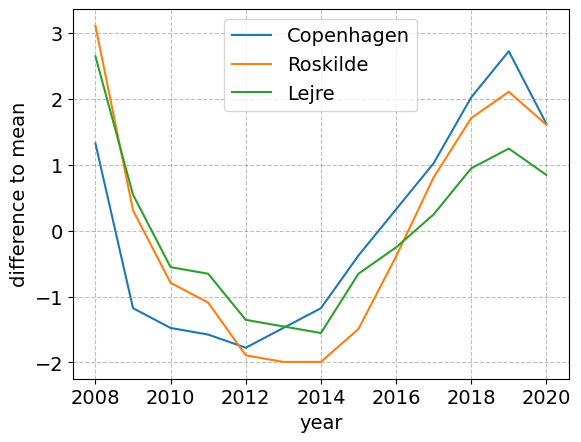

In [16]:
municipalities = ['Copenhagen','Roskilde','Lejre']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Here we use the fact that the index has multiple levels (years) for an elegant loop
for m in municipalities:
    empl_.xs(m).plot(x='year',y='e_demean',ax=ax,label=m)

ax.legend(frameon=True)
ax.set_ylabel('difference to mean')

#### 2.1.1. <a id='toc2_1_1_'></a>[Do the splitting and applying in one fell swoop with `agg()`](#toc0_)

**Agg:** The same value for all observations in a group.  
We can use **lambdas** or **built-in** functions for the operation. ***Use built-in whenever you can!*** Here we use lambda for exposition. 

In [17]:
empl_ = empl.copy()

# a. Good use: a built-in function for mean rather than lambda.
e_mean = empl_.groupby('municipality')['e'].agg('mean')

# Same result with a lambda
#e_mean = empl_.groupby('municipality')['e'].agg(lambda x: x.mean())

e_mean.name = 'e_mean'

# b. combine
empl_ = empl_.set_index('municipality').join(e_mean, how='left')
empl_['diff'] = empl_.e - empl_.e_mean
empl_.xs('Copenhagen')

,year,e,empl_demean,e_mean,diff
municipality,,,,,
Copenhagen,2008,72.5,-1.340249,71.176923,1.323077
Copenhagen,2009,70.0,-3.840249,71.176923,-1.176923
Copenhagen,2010,69.7,-4.140249,71.176923,-1.476923
Copenhagen,2011,69.6,-4.240249,71.176923,-1.576923
Copenhagen,2012,69.4,-4.440249,71.176923,-1.776923
Copenhagen,2013,69.7,-4.140249,71.176923,-1.476923
Copenhagen,2014,70.0,-3.840249,71.176923,-1.176923
Copenhagen,2015,70.8,-3.040249,71.176923,-0.376923
Copenhagen,2016,71.5,-2.340249,71.176923,0.323077


**Note:** Same result!!

**Question** Are there any dangers with the variable name 'diff'?

This is pretty cumbersome though. Creating a new variable and then merging in separate step - we can do better with the tools in Pandas.

#### 2.1.2. <a id='toc2_1_2_'></a>[Splitting, applying and combining all together with - `apply()`  and `transform()` directly](#toc0_)

**Transform:** In case you are dealing with multiple variables, `transform` will work on one variable/column at a time. In the case below, had we selected both *e* and *year* rather than just *e*, x.mean() would and could only have been applied to observations within one column at a time. `transform` has to return an array of size 1 or of the same size as the original column.  
**Apply:** The set of columns passed to the `apply` function is considered to be a whole dataframe on its own. You can therefore make lambda functions that utilizes several columns of data in each operation. That is not possible with the `transform` function.  
**More info:** you can read more about the differences between transform and `apply` [here](https://stackoverflow.com/questions/27517425/apply-vs-transform-on-a-group-object).    

**Note** when you are dealing with selections of **only 1** variable, then `transform` and `apply` behave similarly. 

In [18]:
empl_ = empl.copy()
empl_['e_demean'] = empl_.groupby('municipality')['e'].apply(lambda x:  x - x.mean())

# In this case, you could have used apply as well
#empl_[['e_demean']] = empl_.groupby('municipality')['e'].transform(lambda x: x - x.mean())

empl_.set_index('municipality').xs('Copenhagen')

,year,e,empl_demean,e_demean
municipality,,,,
Copenhagen,2008,72.5,-1.340249,1.323077
Copenhagen,2009,70.0,-3.840249,-1.176923
Copenhagen,2010,69.7,-4.140249,-1.476923
Copenhagen,2011,69.6,-4.240249,-1.576923
Copenhagen,2012,69.4,-4.440249,-1.776923
Copenhagen,2013,69.7,-4.140249,-1.476923
Copenhagen,2014,70.0,-3.840249,-1.176923
Copenhagen,2015,70.8,-3.040249,-0.376923
Copenhagen,2016,71.5,-2.340249,0.323077


## 3. <a id='toc3_'></a>[Optimizing performance](#toc0_)

It is quite important for your own and other's productivity to implement effecient procedures when dealing with large datasets. The **apply** method (as well as the transform) essentially **loops over** the rows of a column when applying a **lambda** function. This may be much **slower** than needed if you for example end up calculating averages over the whole column or group many, many times (one per row) as in the case below. Using pandas functions **without lambdas** gets it right. Important to avoid such behavior with large data sets. 

In [19]:
import time
N = 300

# a. Check performance with lambda function. Sooo slooow.. 
demean = lambda x: x - x.mean()
tic = time.perf_counter()
for i in range(N):
    d1 = empl.groupby('municipality')['e'].transform(demean)
toc = time.perf_counter()
print(f'Performance with lambda function {toc-tic: 5.3f}')

# b. Performance when relying on built-in pandas methods. It is not because we're using transform per se. 
# It's much faster, because mean is not calculated for each row in data and we're in Cython. 
tic = time.perf_counter()
for i in range(N):
    d2 = empl.e - empl.groupby('municipality')['e'].transform('mean') # Demean by subtracting grouped mean from e column.    
toc = time.perf_counter()
print(f'Performance with pandas vectorized: {toc-tic: 5.3f}')

print('Check of consistency: ', np.all(d1==d2))

Performance with lambda function  3.967
Performance with pandas vectorized:  0.141
Check of consistency:  False


We can also see that an explicit numpy implementation is faster than relying on pandas methods. The example with first differencing from above.

In [20]:
# a. The pandas series implementation
avg_first_diff = lambda x: x.diff(1).mean()
tic = time.perf_counter()
for i in range(N):
    d1 = empl.groupby('municipality')['e'].apply(avg_first_diff)
toc = time.perf_counter()
print(f'Performance with pandas: {toc-tic: 3.6f}')

# b. The Numpy implementation
avg_first_diff = lambda x: np.mean(x.values[1:]-x.values[:-1])
tic = time.perf_counter()
for i in range(N):
    d2 = empl.groupby('municipality')['e'].apply(avg_first_diff)
toc = time.perf_counter()
print(f'Performance with numpy: {toc-tic: 3.6f}')
print('Is d1 == d2:', np.all(d1==d2))

Performance with pandas:  2.515890
Performance with numpy:  0.816148
Is d1 == d2: True


**Note:** Same result!!

#### 3.1.1. <a id='toc3_1_1_'></a>[Need more complex group by stuff?](#toc0_)

Look [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

#### 3.1.2. <a id='toc3_1_2_'></a>[Additional links](#toc0_)
* Do you have **missing values** in data? Check [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)
* About strings and the `object`type in pandas, [here](https://towardsdatascience.com/why-we-need-to-use-pandas-new-string-dtype-instead-of-object-for-textual-data-6fd419842e24).
* Comparison of SQL statements and pandas group by [here](https://realpython.com/pandas-groupby/)
* Optimizing pandas routines incl. `apply`, [here](https://realpython.com/fast-flexible-pandas/#pandas-apply). (*less technical*)
* Stackoverflow [musings](https://stackoverflow.com/questions/54432583/when-should-i-not-want-to-use-pandas-apply-in-my-code?noredirect=1&lq=1) on optimal use of apply( ) and it's downsides. See also [this](https://stackoverflow.com/questions/38938318/why-apply-sometimes-isnt-faster-than-for-loop-in-pandas-dataframe). (*both pretty technical*)
* About optimizing pandas with numpy and vectorization, [here](https://devopedia.org/optimizing-pandas).

## 4. <a id='toc4_'></a>[Built-in functions to aggregate data in Pandas](#toc0_)

You can use the functions in `apply()`, `transform()` and `agg()` by writing them out in a string. See above. Will normally be the fastest implementation. 

***Function***	 *Description*


* **count:**	 Number of non-null observations
* **sum:**	 Sum of values
* **mean:**	 Mean of values
* **mad:**	 Mean absolute deviation
* **min:**	 Minimum
* **max:**	 Maximum
* **mode:**	 Mode
* **abs:**	 Absolute Value
* **prod:**	 Product of values
* **std:**	 Unbiased standard deviation
* **var:**	 Unbiased variance
* **sem:**	 Unbiased standard error of the mean
* **skew:**	 Unbiased skewness (3rd moment)
* **kurt:**	 Unbiased kurtosis (4th moment)
* **quantile:**	 Sample quantile (value at %)
* **cumsum:**	 Cumulative sum
* **cumprod:**	 Cumulative product
* **cummax:**	 Cumulative maximum
* **cummin:**	 Cumulative minimum

There is also your [DataCamp cheatsheet](https://www.datacamp.com/community/blog/python-pandas-cheat-sheet) for pandas for references.